# 8.4

# 8

In [1]:
pip install ISLP;

Note: you may need to restart the kernel to use updated packages.


In [2]:
import numpy as np
import pandas as pd
from matplotlib.pyplot import subplots
from statsmodels.datasets import get_rdataset
import sklearn.model_selection as skm
from ISLP import load_data, confusion_table
from ISLP.models import ModelSpec as MS

In [3]:
from sklearn.tree import (DecisionTreeClassifier as DTC,
      DecisionTreeRegressor as DTR,
      plot_tree,
      export_text)
from sklearn.metrics import (accuracy_score,
      log_loss)
from sklearn.ensemble import \
    (RandomForestRegressor as RF,
    GradientBoostingRegressor as GBR)
from ISLP.bart import BART

In [4]:
Carseats = load_data('Carseats')
Carseats.head(5)

,Sales,CompPrice,Income,Advertising,Population,Price,ShelveLoc,Age,Education,Urban,US
0,9.50,138,73,11,276,120,Bad,42,17,Yes,Yes
1,11.22,111,48,16,260,83,Good,65,10,Yes,Yes
2,10.06,113,35,10,269,80,Medium,59,12,Yes,Yes
3,7.40,117,100,4,466,97,Medium,55,14,Yes,Yes
4,4.15,141,64,3,340,128,Bad,38,13,Yes,No


In [5]:
model = MS(Carseats.columns.drop('Sales'), intercept=False)
D = model.fit_transform(Carseats)
feature_names = list(D.columns)
X = np.asarray(D)

In [6]:
print(feature_names)

['CompPrice', 'Income', 'Advertising', 'Population', 'Price', 'ShelveLoc[Good]', 'ShelveLoc[Medium]', 'Age', 'Education', 'Urban[Yes]', 'US[Yes]']


# (a)

In [7]:
#creating test set with 30 percent of the dataset
from sklearn.model_selection import train_test_split

y = Carseats['Sales']
 
# split the dataset
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=0)

# (b)

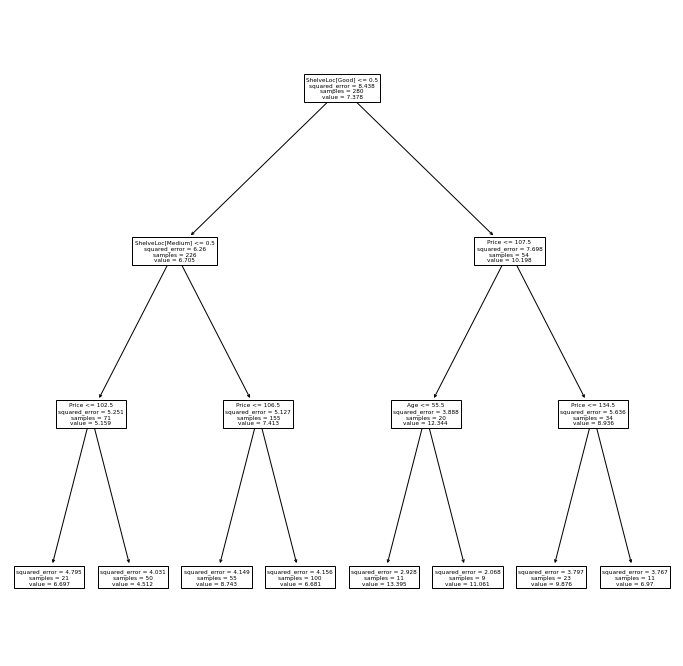

In [8]:
reg = DTR(max_depth=3)
reg.fit(X_train, y_train)
ax = subplots(figsize=(12,12))[1]
plot_tree(reg,
          feature_names=feature_names,
          ax=ax);

In [9]:
#Representing tree with text
print(export_text(reg,
      feature_names=feature_names,
      show_weights=True))

|--- ShelveLoc[Good] <= 0.50
|   |--- ShelveLoc[Medium] <= 0.50
|   |   |--- Price <= 102.50
|   |   |   |--- value: [6.70]
|   |   |--- Price >  102.50
|   |   |   |--- value: [4.51]
|   |--- ShelveLoc[Medium] >  0.50
|   |   |--- Price <= 106.50
|   |   |   |--- value: [8.74]
|   |   |--- Price >  106.50
|   |   |   |--- value: [6.68]
|--- ShelveLoc[Good] >  0.50
|   |--- Price <= 107.50
|   |   |--- Age <= 55.50
|   |   |   |--- value: [13.39]
|   |   |--- Age >  55.50
|   |   |   |--- value: [11.06]
|   |--- Price >  107.50
|   |   |--- Price <= 134.50
|   |   |   |--- value: [9.88]
|   |   |--- Price >  134.50
|   |   |   |--- value: [6.97]



3.7038582752360956

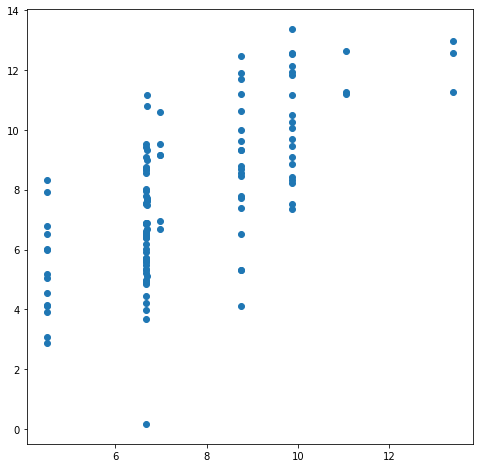

In [10]:
#scatterplot of true label vs predicted label and test MSE
ax = subplots(figsize=(8,8))[1]
y_hat = reg.predict(X_test)
ax.scatter(y_hat, y_test)
np.mean((y_test - y_hat)**2)

# (c)

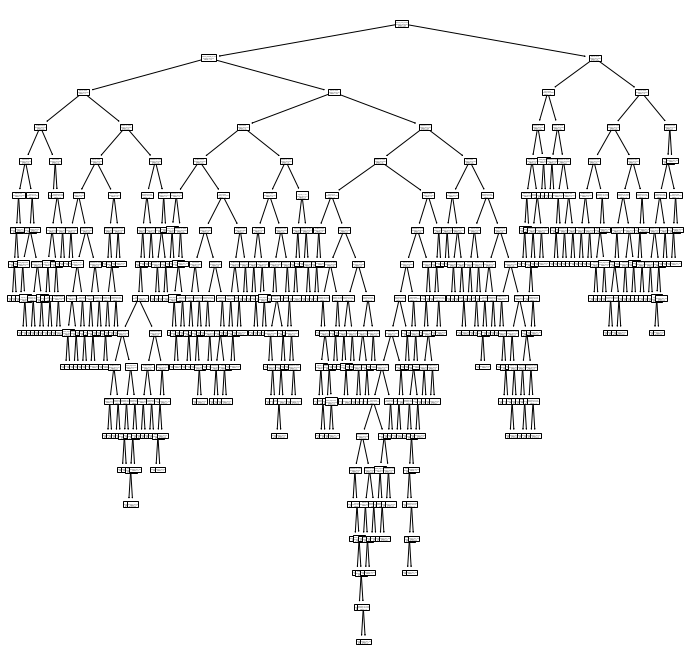

In [11]:
reg = DTR()
reg.fit(X_train, y_train)
ax = subplots(figsize=(12,12))[1]
plot_tree(reg,
          feature_names=feature_names,
          ax=ax);

5.633752499999996

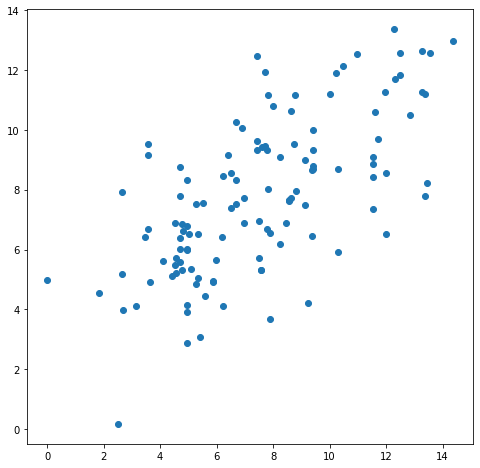

In [12]:
#scatterplot of true label vs predicted label and test MSE
ax = subplots(figsize=(8,8))[1]
y_hat = reg.predict(X_test)
ax.scatter(y_hat, y_test)
np.mean((y_test - y_hat)**2)

In [13]:
#Pruning
ccp_path = reg.cost_complexity_pruning_path(X_train, y_train)
kfold = skm.KFold(5,
                  shuffle=True,
                  random_state=10)
grid = skm.GridSearchCV(reg,
                        {'ccp_alpha': ccp_path.ccp_alphas},
                        refit=True,
                        cv=kfold,
                        scoring='neg_mean_squared_error')
G = grid.fit(X_train, y_train)

In [14]:
best_ = grid.best_estimator_
np.mean((y_test - best_.predict(X_test))**2)

4.851659429865833

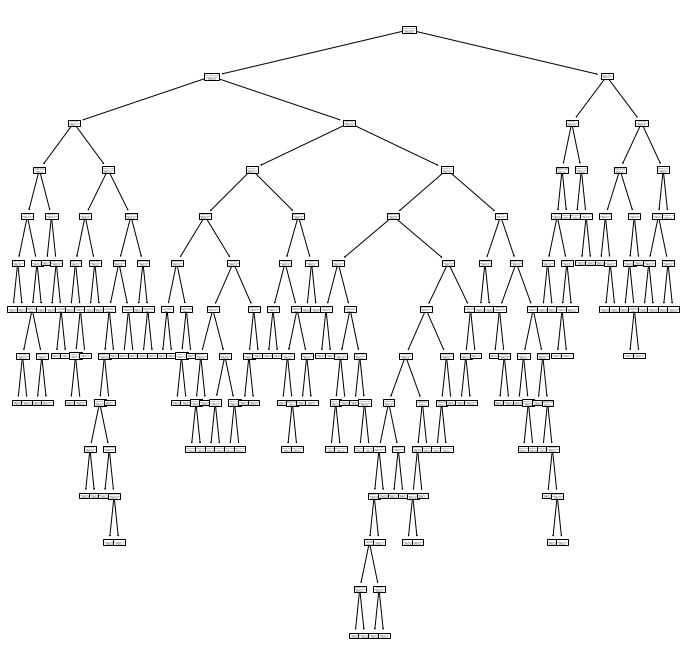

In [15]:
ax = subplots(figsize=(12,12))[1]
plot_tree(G.best_estimator_,
          feature_names=feature_names,
          ax=ax);

In [16]:
#Cross validation to test for different max depths
#ccp_path = reg.cost_complexity_pruning_path(X_train, y_train)
kfold = skm.KFold(5,
                  shuffle=True,
                  random_state=10)
tree_para = {'max_depth':[2,3,4,5,6,7,8,9,10,11,12]}
grid = skm.GridSearchCV(reg,
                        tree_para,
                        refit=True,
                        cv=kfold,
                        scoring='neg_mean_squared_error')
G = grid.fit(X_train, y_train)
print(G)

GridSearchCV(cv=KFold(n_splits=5, random_state=10, shuffle=True),
             estimator=DecisionTreeRegressor(),
             param_grid={'max_depth': [2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12]},
             scoring='neg_mean_squared_error')


In [17]:
best_ = grid.best_estimator_
np.mean((y_test - best_.predict(X_test))**2)

4.525676535006564

In [18]:
print(best_)

DecisionTreeRegressor(max_depth=6)


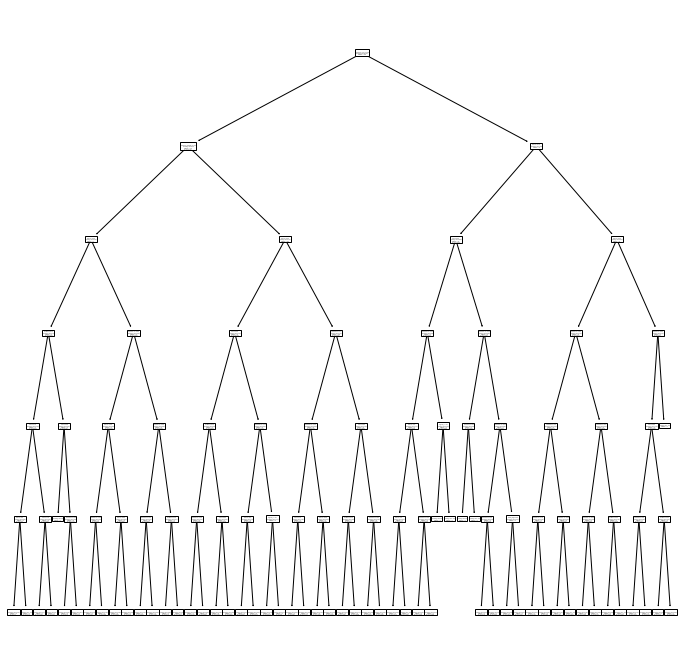

In [19]:
ax = subplots(figsize=(12,12))[1]
plot_tree(G.best_estimator_,
          feature_names=feature_names,
          ax=ax);

4.525676535006564

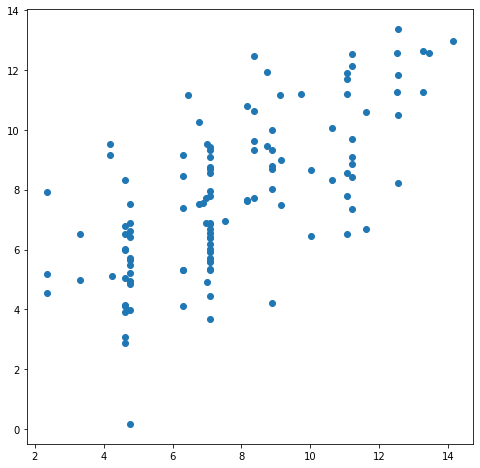

In [20]:
ax = subplots(figsize=(8,8))[1]
y_hat = best_.predict(X_test)
ax.scatter(y_hat, y_test)
np.mean((y_test - y_hat)**2)

In [21]:
#Pruning
ccp_path = best_.cost_complexity_pruning_path(X_train, y_train)
kfold = skm.KFold(5,
                  shuffle=True,
                  random_state=10)
grid = skm.GridSearchCV(best_,
                        {'ccp_alpha': ccp_path.ccp_alphas},
                        refit=True,
                        cv=kfold,
                        scoring='neg_mean_squared_error')
G = grid.fit(X_train, y_train)

In [22]:
best_ = grid.best_estimator_
np.mean((y_test - best_.predict(X_test))**2)

4.224841025165057

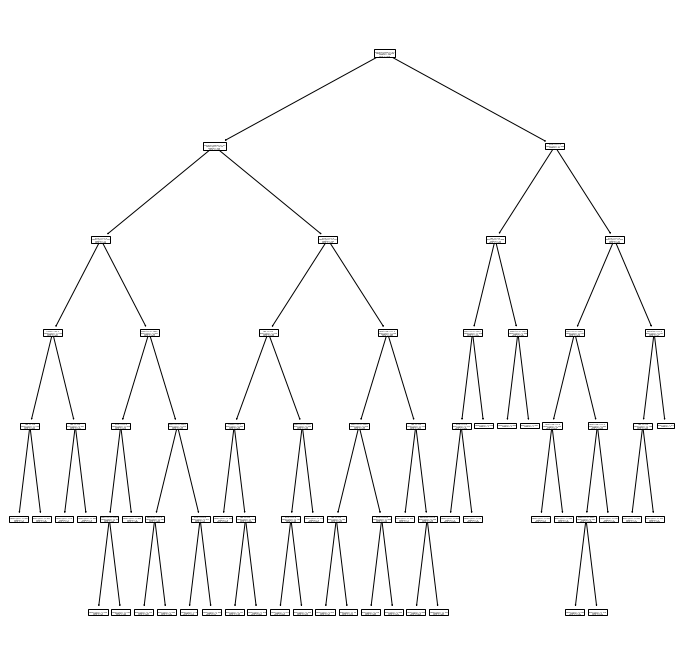

In [23]:
ax = subplots(figsize=(12,12))[1]
plot_tree(G.best_estimator_,
          feature_names=feature_names,
          ax=ax);

4.224841025165057

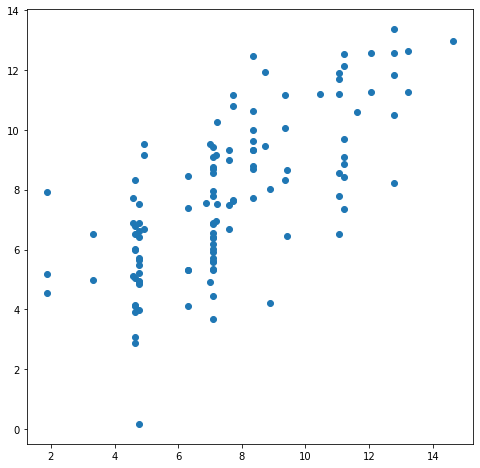

In [24]:
ax = subplots(figsize=(8,8))[1]
y_hat = best_.predict(X_test)
ax.scatter(y_hat, y_test)
np.mean((y_test - y_hat)**2)

# (d)

In [25]:
bag_carseats = RF(max_features=X_train.shape[1], random_state=0)
bag_carseats.fit(X_train, y_train)

RandomForestRegressor(max_features=11, random_state=0)

2.007744519750003

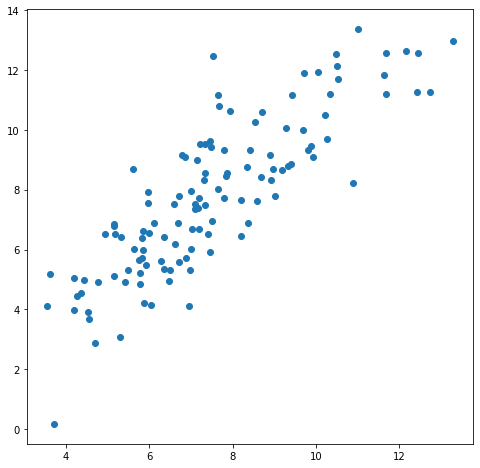

In [26]:
ax = subplots(figsize=(8,8))[1]
y_hat_bag = bag_carseats.predict(X_test)
ax.scatter(y_hat_bag, y_test)
np.mean((y_test - y_hat_bag)**2)

In [27]:
#changing number of trees
bag_carseats = RF(max_features=X_train.shape[1],
                n_estimators=500,
                random_state=0).fit(X_train, y_train)
y_hat_bag = bag_carseats.predict(X_test)
np.mean((y_test - y_hat_bag)**2)

2.0236328641333428

In [28]:
#changing number of trees
bag_carseats = RF(max_features=X_train.shape[1],
                n_estimators=80,
                random_state=0).fit(X_train, y_train)
y_hat_bag = bag_carseats.predict(X_test)
np.mean((y_test - y_hat_bag)**2)

2.0299576269531268

In [29]:
#changing number of trees
bag_carseats = RF(max_features=X_train.shape[1],
                n_estimators=120,
                random_state=0).fit(X_train, y_train)
y_hat_bag = bag_carseats.predict(X_test)
np.mean((y_test - y_hat_bag)**2)

2.0614932343171315

In [30]:
feature_imp = pd.DataFrame(
                          {'importance':bag_carseats.feature_importances_},
                          index=feature_names)
feature_imp.sort_values(by='importance', ascending=False)

,importance
Price,0.280663
ShelveLoc[Good],0.220696
Age,0.109453
CompPrice,0.097915
ShelveLoc[Medium],0.082481
Advertising,0.072299
Income,0.052147
Population,0.041558
Education,0.031427
US[Yes],0.006551


# (e)

In [31]:
RF_carseats = RF(max_features=6,
              random_state=0).fit(X_train, y_train)
y_hat_RF = RF_carseats.predict(X_test)
np.mean((y_test - y_hat_RF)**2)

2.010414250999999

In [32]:
feature_imp = pd.DataFrame(
                          {'importance':RF_carseats.feature_importances_},
                          index=feature_names)
feature_imp.sort_values(by='importance', ascending=False)

,importance
Price,0.274081
ShelveLoc[Good],0.185368
Age,0.116413
CompPrice,0.103326
Advertising,0.083759
Income,0.064661
ShelveLoc[Medium],0.062402
Population,0.054959
Education,0.036506
US[Yes],0.011148


In [33]:
#changing m/number od features considered at each split
RF_carseats = RF(max_features=4,
              random_state=0).fit(X_train, y_train)
y_hat_RF = RF_carseats.predict(X_test)
np.mean((y_test - y_hat_RF)**2)

2.162177176749999

In [34]:
RF_carseats = RF(max_features=2,
              random_state=0).fit(X_train, y_train)
y_hat_RF = RF_carseats.predict(X_test)
np.mean((y_test - y_hat_RF)**2)

2.9053707589999993

In [35]:
RF_carseats = RF(max_features=8,
              random_state=0).fit(X_train, y_train)
y_hat_RF = RF_carseats.predict(X_test)
np.mean((y_test - y_hat_RF)**2)

1.9978001218333337

In [36]:
RF_carseats = RF(max_features=10,
              random_state=0).fit(X_train, y_train)
y_hat_RF = RF_carseats.predict(X_test)
np.mean((y_test - y_hat_RF)**2)

2.064451973666667

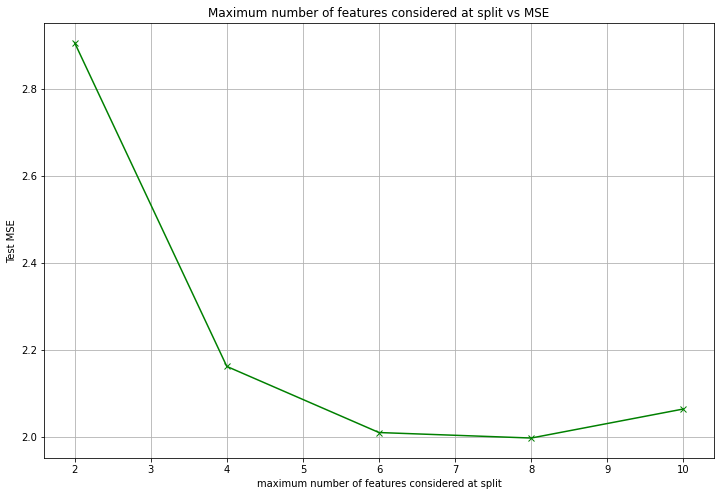

In [37]:
import matplotlib.pyplot as plt 
no_of_features=[2,4,6,8,10]
mse=[2.9053707589999993,2.162177176749999,2.010414250999999,1.9978001218333337,2.064451973666667]
fig = plt.figure(figsize=(12, 8))
ax = fig.add_subplot(111)
plt.plot(no_of_features, mse,marker="x", color='g')
ax.set_xlabel('maximum number of features considered at split')
ax.set_ylabel('Test MSE')
ax.set_title('Maximum number of features considered at split vs MSE')
plt.grid()
plt.show()

# 9

In [38]:
OJ = load_data('OJ')
OJ.head(5)

,Purchase,WeekofPurchase,StoreID,PriceCH,PriceMM,DiscCH,DiscMM,SpecialCH,SpecialMM,LoyalCH,SalePriceMM,SalePriceCH,PriceDiff,Store7,PctDiscMM,PctDiscCH,ListPriceDiff,STORE
0,CH,237,1,1.75,1.99,0.00,0.0,0,0,0.500000,1.99,1.75,0.24,No,0.000000,0.000000,0.24,1
1,CH,239,1,1.75,1.99,0.00,0.3,0,1,0.600000,1.69,1.75,-0.06,No,0.150754,0.000000,0.24,1
2,CH,245,1,1.86,2.09,0.17,0.0,0,0,0.680000,2.09,1.69,0.40,No,0.000000,0.091398,0.23,1
3,MM,227,1,1.69,1.69,0.00,0.0,0,0,0.400000,1.69,1.69,0.00,No,0.000000,0.000000,0.00,1
4,CH,228,7,1.69,1.69,0.00,0.0,0,0,0.956535,1.69,1.69,0.00,Yes,0.000000,0.000000,0.00,0


In [39]:
OJ.shape

(1070, 18)

In [40]:
test_proportion=(OJ.shape[0]-800)/OJ.shape[0]
print(test_proportion)

0.2523364485981308


# (a)

In [41]:
X = OJ.drop('Purchase',axis=1)
X.head()

,WeekofPurchase,StoreID,PriceCH,PriceMM,DiscCH,DiscMM,SpecialCH,SpecialMM,LoyalCH,SalePriceMM,SalePriceCH,PriceDiff,Store7,PctDiscMM,PctDiscCH,ListPriceDiff,STORE
0,237,1,1.75,1.99,0.00,0.0,0,0,0.500000,1.99,1.75,0.24,No,0.000000,0.000000,0.24,1
1,239,1,1.75,1.99,0.00,0.3,0,1,0.600000,1.69,1.75,-0.06,No,0.150754,0.000000,0.24,1
2,245,1,1.86,2.09,0.17,0.0,0,0,0.680000,2.09,1.69,0.40,No,0.000000,0.091398,0.23,1
3,227,1,1.69,1.69,0.00,0.0,0,0,0.400000,1.69,1.69,0.00,No,0.000000,0.000000,0.00,1
4,228,7,1.69,1.69,0.00,0.0,0,0,0.956535,1.69,1.69,0.00,Yes,0.000000,0.000000,0.00,0


In [42]:
from sklearn import preprocessing
lab_enc = preprocessing.LabelEncoder()
encoded_store7 = lab_enc.fit_transform(X['Store7'])
print(encoded_store7)

[0 0 0 ... 1 1 0]


In [43]:
X['enc_store7']=encoded_store7
X = X.drop('Store7',axis=1)
X.head()


,WeekofPurchase,StoreID,PriceCH,PriceMM,DiscCH,DiscMM,SpecialCH,SpecialMM,LoyalCH,SalePriceMM,SalePriceCH,PriceDiff,PctDiscMM,PctDiscCH,ListPriceDiff,STORE,enc_store7
0,237,1,1.75,1.99,0.00,0.0,0,0,0.500000,1.99,1.75,0.24,0.000000,0.000000,0.24,1,0
1,239,1,1.75,1.99,0.00,0.3,0,1,0.600000,1.69,1.75,-0.06,0.150754,0.000000,0.24,1,0
2,245,1,1.86,2.09,0.17,0.0,0,0,0.680000,2.09,1.69,0.40,0.000000,0.091398,0.23,1,0
3,227,1,1.69,1.69,0.00,0.0,0,0,0.400000,1.69,1.69,0.00,0.000000,0.000000,0.00,1,0
4,228,7,1.69,1.69,0.00,0.0,0,0,0.956535,1.69,1.69,0.00,0.000000,0.000000,0.00,0,1


In [44]:
y = OJ['Purchase']
y.head()

0    CH
1    CH
2    CH
3    MM
4    CH
Name: Purchase, dtype: object

In [45]:
#encoding y
lab_enc = preprocessing.LabelEncoder()
encoded_Y = lab_enc.fit_transform(y)
print(encoded_Y)

[0 0 0 ... 1 0 0]


In [46]:
# split the dataset
X_train, X_test, y_train, y_test = train_test_split(
    X, encoded_Y, test_size=test_proportion, random_state=4)

In [47]:
X_test.head()

,WeekofPurchase,StoreID,PriceCH,PriceMM,DiscCH,DiscMM,SpecialCH,SpecialMM,LoyalCH,SalePriceMM,SalePriceCH,PriceDiff,PctDiscMM,PctDiscCH,ListPriceDiff,STORE,enc_store7
260,267,2,1.86,2.18,0.0,0.4,0,1,0.384000,1.78,1.86,-0.08,0.183486,0.0,0.32,2,0
594,256,7,1.86,2.18,0.0,0.0,0,0,0.829606,2.18,1.86,0.32,0.000000,0.0,0.32,0,1
786,234,3,1.79,2.09,0.0,0.0,0,0,0.067109,2.09,1.79,0.30,0.000000,0.0,0.30,3,0
669,254,4,1.99,2.29,0.0,0.0,1,0,0.500000,2.29,1.99,0.30,0.000000,0.0,0.30,4,0
179,246,4,1.99,2.23,0.0,0.0,0,0,0.994235,2.23,1.99,0.24,0.000000,0.0,0.24,4,0


# (b)

In [48]:
#Response is categorical, hence we use a claasification tree
clf1= DTC(criterion='entropy',
      #max_depth=3,
      random_state=0)
clf1.fit(X_train, y_train)

DecisionTreeClassifier(criterion='entropy', random_state=0)

# (j)

In [49]:
#unpruned tree training accuracy and error 
accuracy_score(y_train, clf1.predict(X_train))

0.9925

In [50]:
print("training error=",100*(1-0.9925),'%')

training error= 0.7499999999999951 %


# (c)

In [51]:

feature_names = list(X.columns)

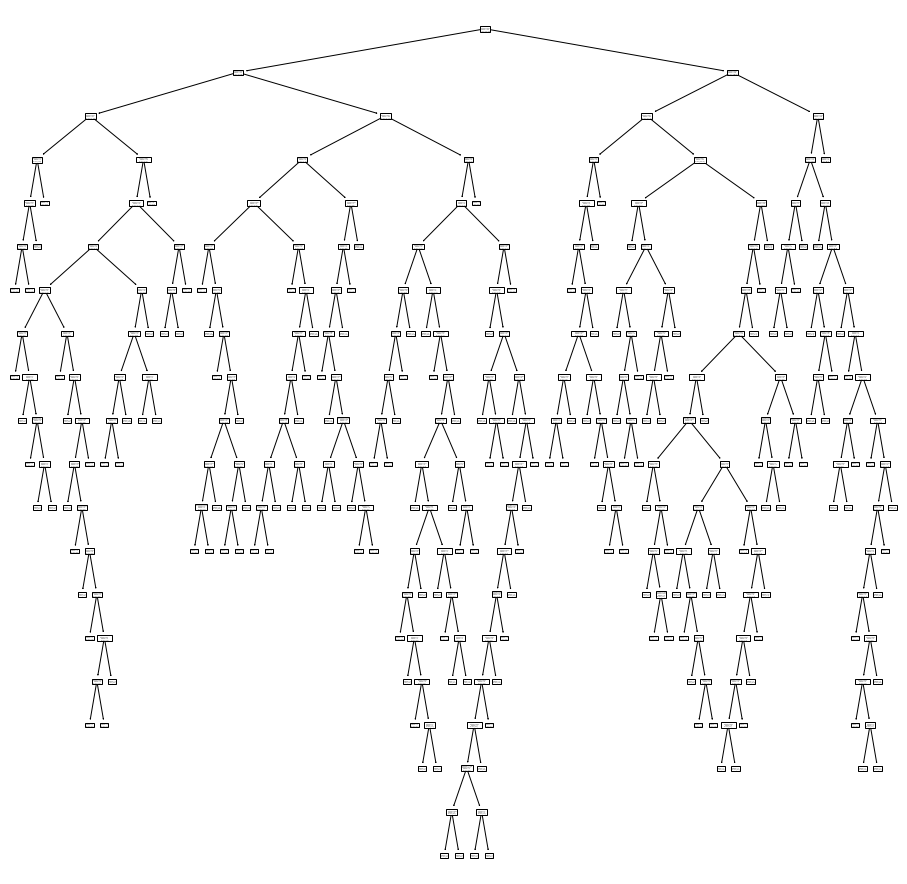

In [52]:
#plotting
ax = subplots(figsize=(16,16))[1]
plot_tree(clf1,
          feature_names=feature_names,
          ax=ax);

# (d)

In [53]:
print(export_text(clf1,
      feature_names=feature_names,
      show_weights=True))

|--- LoyalCH <= 0.50
|   |--- LoyalCH <= 0.28
|   |   |--- LoyalCH <= 0.04
|   |   |   |--- StoreID <= 2.50
|   |   |   |   |--- LoyalCH <= 0.00
|   |   |   |   |   |--- LoyalCH <= 0.00
|   |   |   |   |   |   |--- weights: [0.00, 2.00] class: 1
|   |   |   |   |   |--- LoyalCH >  0.00
|   |   |   |   |   |   |--- weights: [1.00, 0.00] class: 0
|   |   |   |   |--- LoyalCH >  0.00
|   |   |   |   |   |--- weights: [0.00, 7.00] class: 1
|   |   |   |--- StoreID >  2.50
|   |   |   |   |--- weights: [0.00, 47.00] class: 1
|   |   |--- LoyalCH >  0.04
|   |   |   |--- WeekofPurchase <= 273.50
|   |   |   |   |--- WeekofPurchase <= 263.50
|   |   |   |   |   |--- STORE <= 1.50
|   |   |   |   |   |   |--- ListPriceDiff <= 0.18
|   |   |   |   |   |   |   |--- LoyalCH <= 0.15
|   |   |   |   |   |   |   |   |--- weights: [3.00, 0.00] class: 0
|   |   |   |   |   |   |   |--- LoyalCH >  0.15
|   |   |   |   |   |   |   |   |--- WeekofPurchase <= 228.50
|   |   |   |   |   |   |   |   |   |--

# (c)

In [54]:
#number of nodes
print (clf1.tree_.node_count)

345


In [55]:
nodedepths=clf1.tree_.compute_node_depths()
print(clf1.tree_.compute_node_depths())

[ 1  2  3  4  5  6  7  7  6  5  4  5  6  7  8  9  9 10 10 11 11 12 12  8
  9  9 10 10 11 12 12 13 13 14 14 15 15 16 17 17 16 11  7  8  9 10 11 11
 10  9 10 10  8  6  7  8  8  7  5  3  4  5  6  7  7  8  8  9  9 10 11 12
 13 13 12 11 12 13 13 12 10  6  7  7  8  9 10 11 12 13 13 12 11 12 12 10
  9  8  5  6  7  8  9  9 10 10 11 12 12 11 12 12 13 13  8  7  6  4  5  6
  7  8  9 10 11 11 10  9  8  7  8  8  9  9 10 11 12 12 13 14 15 15 16 16
 17 17 18 18 14 13 14 14 15 15 16 16 11 12 12 13 13 10  6  7  8  8  9 10
 10 11 11  9 10 10 11 12 13 14 15 16 17 18 19 20 20 19 20 20 18 17 16 15
 14 13 12 11  7  5  2  3  4  5  6  7  7  8  9 10 11 11 10  9 10 10 11 11
 12 12 13 13  8  6  5  4  5  6  6  7  8  8  9 10 10 11 11  9  7  8  9 10
 10  9  8  5  6  7  8  9 10 11 12 12 13 14 14 15 15 13 11 12 13 14 14 15
 15 16 16 17 17 13 14 14 12 13 13 14 15 16 17 18 18 17 16 15 14 10  9 10
 11 11 12 12 10 11 11  8  7  6  3  4  5  6  7  8  8  7  6  5  6  6  7  8
  8  9 10 10  9  7  8  8  9  9 10 11 12 12 11 10 11

In [56]:
print(type(clf1.tree_.compute_node_depths()))

<class 'numpy.ndarray'>


In [57]:
terminal_depth=max(nodedepths)
print(terminal_depth)

20


In [58]:
#count of nodes with max depth
terminal=[]
for depth in nodedepths:
    if depth==terminal_depth:
        terminal.append(depth)
print(terminal,len(terminal))
    

[20, 20, 20, 20] 4


In [59]:
clf2 = DTC(criterion='entropy',
      max_depth=3,
      random_state=0)
clf2.fit(X_train, y_train)

DecisionTreeClassifier(criterion='entropy', max_depth=3, random_state=0)

In [60]:
#training accuracy
accuracy_score(y_train, clf2.predict(X_train))

0.83125

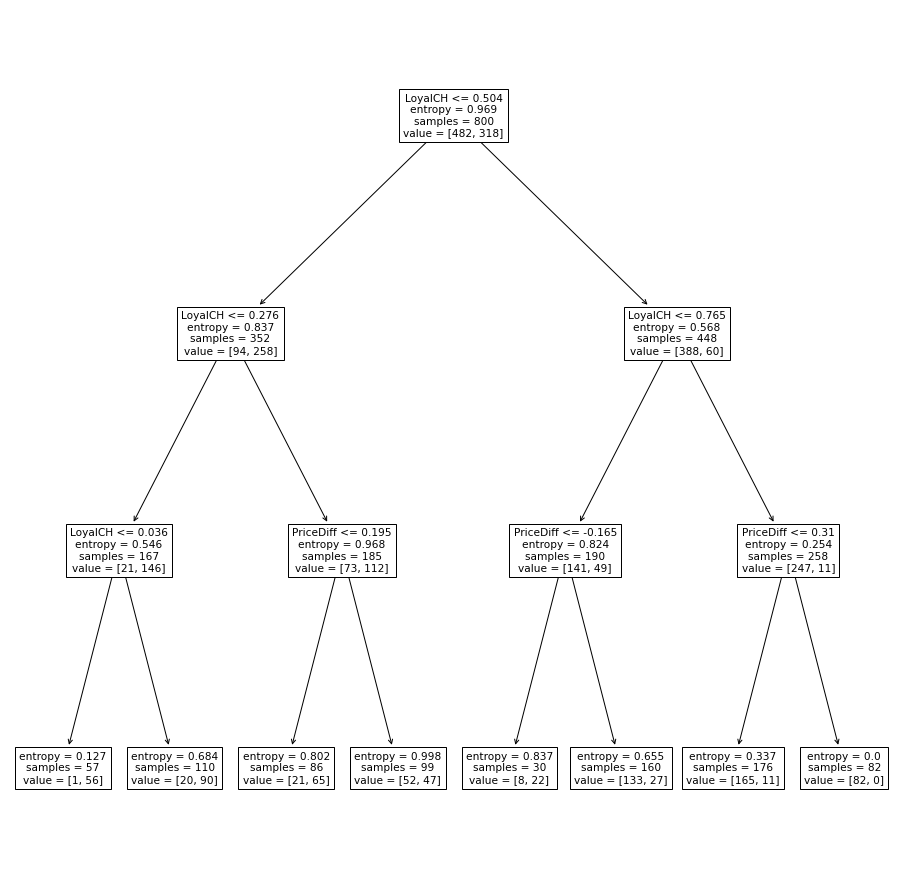

In [61]:
#plotting
ax = subplots(figsize=(16,16))[1]
plot_tree(clf2,
          feature_names=feature_names,
          ax=ax);

# (d)

In [62]:
print(export_text(clf2,
      feature_names=feature_names,
      show_weights=True))

|--- LoyalCH <= 0.50
|   |--- LoyalCH <= 0.28
|   |   |--- LoyalCH <= 0.04
|   |   |   |--- weights: [1.00, 56.00] class: 1
|   |   |--- LoyalCH >  0.04
|   |   |   |--- weights: [20.00, 90.00] class: 1
|   |--- LoyalCH >  0.28
|   |   |--- PriceDiff <= 0.20
|   |   |   |--- weights: [21.00, 65.00] class: 1
|   |   |--- PriceDiff >  0.20
|   |   |   |--- weights: [52.00, 47.00] class: 0
|--- LoyalCH >  0.50
|   |--- LoyalCH <= 0.76
|   |   |--- PriceDiff <= -0.16
|   |   |   |--- weights: [8.00, 22.00] class: 1
|   |   |--- PriceDiff >  -0.16
|   |   |   |--- weights: [133.00, 27.00] class: 0
|   |--- LoyalCH >  0.76
|   |   |--- PriceDiff <= 0.31
|   |   |   |--- weights: [165.00, 11.00] class: 0
|   |   |--- PriceDiff >  0.31
|   |   |   |--- weights: [82.00, 0.00] class: 0



In [63]:
print (clf2.tree_.node_count)

15


# (e)

In [64]:
#test accuracy of tree 1 
accuracy_score(y_test, clf1.predict(X_test))

0.7851851851851852

In [65]:
#test accuracy of tree 2
accuracy_score(y_test, clf2.predict(X_test))

0.8481481481481481

In [66]:
#confusin matrix for test data corresponding to tree 1
print(accuracy_score(y_test,
      clf1.predict(X_test)))
confusion = confusion_table(clf1.predict(X_test),
      y_test)
confusion

0.7851851851851852


Truth,0,1
Predicted,,
0,143,30
1,28,69


In [67]:
#confusin matrix for test data corresponding to tree 2
print(accuracy_score(y_test,
      clf2.predict(X_test)))
confusion = confusion_table(clf2.predict(X_test),
      y_test)
confusion

0.8481481481481481


Truth,0,1
Predicted,,
0,155,25
1,16,74


# (f)

In [68]:
#Cross validation to test for different max depths
#ccp_path = reg.cost_complexity_pruning_path(X_train, y_train)
kfold = skm.KFold(5,
                  shuffle=True,
                  random_state=10)
tree_para = {'max_depth':[3,5,6,7,8,9,11,12,14,16,18]}
grid = skm.GridSearchCV(clf1,
                        tree_para,
                        refit=True,
                        cv=kfold,
                        scoring='neg_mean_squared_error')
G = grid.fit(X_train, y_train)
print(G)

GridSearchCV(cv=KFold(n_splits=5, random_state=10, shuffle=True),
             estimator=DecisionTreeClassifier(criterion='entropy',
                                              random_state=0),
             param_grid={'max_depth': [3, 5, 6, 7, 8, 9, 11, 12, 14, 16, 18]},
             scoring='neg_mean_squared_error')


In [69]:
best_ = grid.best_estimator_

In [70]:
print(accuracy_score(y_test, best_.predict(X_test)))
confusion = confusion_table(best_.predict(X_test),
      y_test)
confusion

0.8222222222222222


Truth,0,1
Predicted,,
0,152,29
1,19,70


# (h)

In [71]:
print(best_)

DecisionTreeClassifier(criterion='entropy', max_depth=6, random_state=0)


# (g)

In [72]:
res=grid.cv_results_

In [73]:
print(res)

{'mean_fit_time': array([0.01562533, 0.0144083 , 0.0129025 , 0.01248055, 0.01680875,
       0.02519045, 0.01884646, 0.01957307, 0.01791286, 0.02208905,
       0.01884604]), 'std_fit_time': array([5.84722914e-05, 4.19929589e-03, 3.76576436e-03, 6.30268457e-03,
       9.15766630e-03, 7.81802649e-03, 6.19833428e-03, 6.12155567e-03,
       7.13812486e-03, 7.47734649e-03, 6.21194229e-03]), 'mean_score_time': array([0.00315995, 0.00565453, 0.        , 0.        , 0.00529752,
       0.00312653, 0.0093822 , 0.00561957, 0.0063427 , 0.00614076,
       0.00624928]), 'std_score_time': array([0.0063199 , 0.00554602, 0.        , 0.        , 0.00648981,
       0.00625305, 0.00766058, 0.00598473, 0.00776945, 0.00752358,
       0.00765379]), 'param_max_depth': masked_array(data=[3, 5, 6, 7, 8, 9, 11, 12, 14, 16, 18],
             mask=[False, False, False, False, False, False, False, False,
                   False, False, False],
       fill_value='?',
            dtype=object), 'params': [{'max_depth

In [74]:
type(res)

dict

In [75]:
params=res['params']
print(params)

[{'max_depth': 3}, {'max_depth': 5}, {'max_depth': 6}, {'max_depth': 7}, {'max_depth': 8}, {'max_depth': 9}, {'max_depth': 11}, {'max_depth': 12}, {'max_depth': 14}, {'max_depth': 16}, {'max_depth': 18}]


In [76]:
std_test_score=res['std_test_score']
print(std_test_score)

[0.0293151  0.02866836 0.02573908 0.02284458 0.02391391 0.01457738
 0.0144698  0.01610512 0.03020761 0.03377314 0.02610077]


In [77]:
max_depth=res['param_max_depth']
print(max_depth)

[3 5 6 7 8 9 11 12 14 16 18]


In [78]:
y=res['mean_test_score']
print(y)

[-0.20625 -0.19125 -0.18875 -0.20125 -0.19625 -0.20375 -0.21125 -0.21625
 -0.2075  -0.2125  -0.20875]


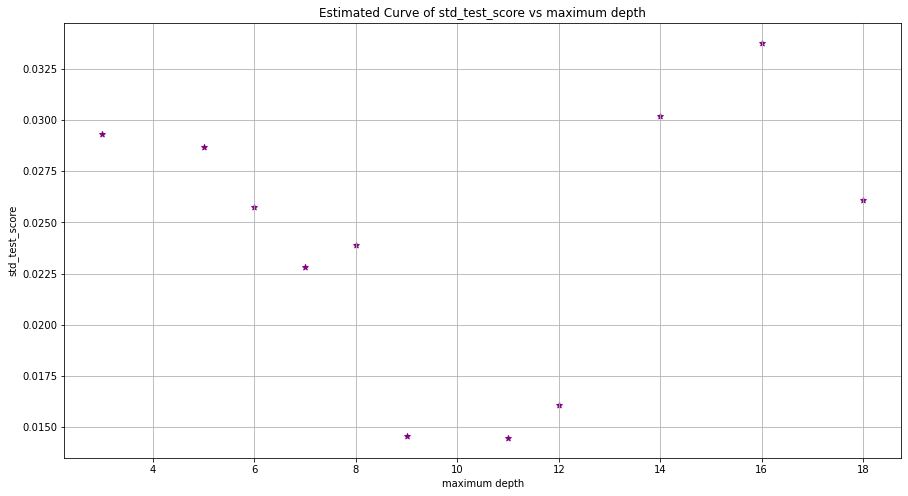

In [79]:

fig = plt.figure(figsize=(15, 8))
ax = fig.add_subplot(111)
plt.scatter(max_depth, std_test_score, marker="*", color='purple')
ax.set_xlabel('maximum depth')
ax.set_ylabel('std_test_score')
ax.set_title('Estimated Curve of std_test_score vs maximum depth')
plt.grid()
plt.show()


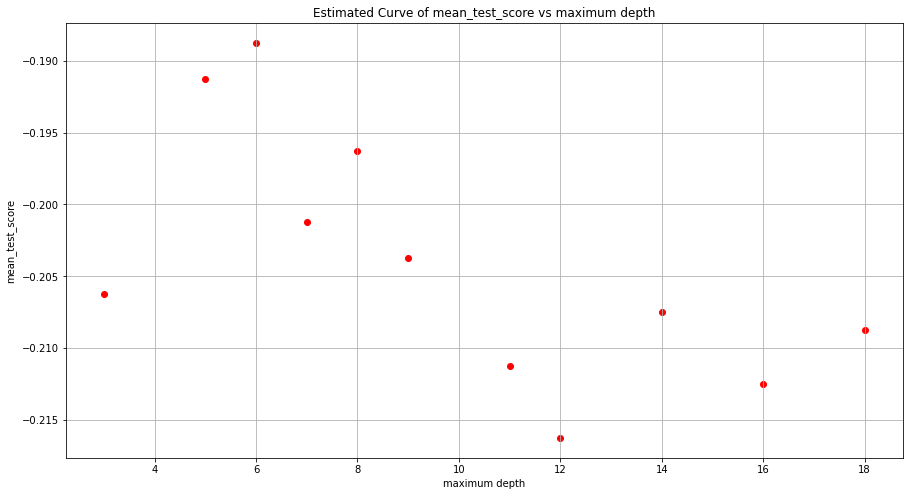

In [80]:

fig = plt.figure(figsize=(15, 8))
ax = fig.add_subplot(111)
plt.scatter(max_depth, y, marker="o", color='r')
ax.set_xlabel('maximum depth')
ax.set_ylabel('mean_test_score')
ax.set_title('Estimated Curve of mean_test_score vs maximum depth')
plt.grid()
plt.show()


# (i)

In [81]:
ccp_path = clf1.cost_complexity_pruning_path(X_train, y_train)
kfold = skm.KFold(10,
                  random_state=1,
                  shuffle=True)

In [82]:
grid = skm.GridSearchCV(clf1,
                      {'ccp_alpha': ccp_path.ccp_alphas},
                      refit=True,
                        cv=kfold,
                      scoring='accuracy')
grid.fit(X_train, y_train)
grid.best_score_

0.8099999999999999

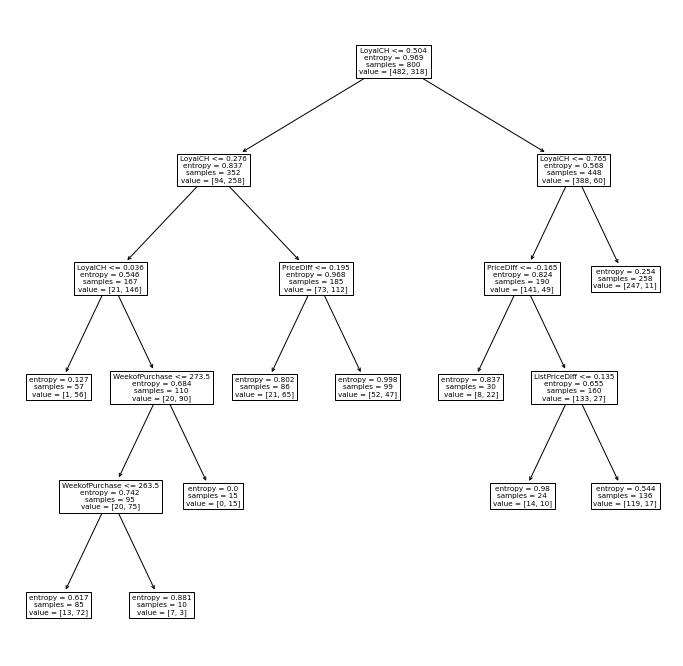

In [83]:
ax = subplots(figsize=(12, 12))[1]
best_ = grid.best_estimator_
plot_tree(best_,
          feature_names=feature_names,
          ax=ax);

In [84]:
print(accuracy_score(y_test,
      best_.predict(X_test)))
confusion = confusion_table(best_.predict(X_test),
      y_test)
confusion

0.8407407407407408


Truth,0,1
Predicted,,
0,155,27
1,16,72


In [85]:
print(best_)

DecisionTreeClassifier(ccp_alpha=0.007791407710224338, criterion='entropy',
                       random_state=0)


# (j)

In [86]:
#unpruned tree training accuracy and error
print(accuracy_score(y_train,
      clf1.predict(X_train)))
confusion = confusion_table(clf1.predict(X_train),
      y_train)
confusion

0.9925


Truth,0,1
Predicted,,
0,481,5
1,1,313


In [87]:
print('Error of unpruned tree on training data=',(1-accuracy_score(y_train,clf1.predict(X_train)))*100,'%')

Error of unpruned tree on training data= 0.7499999999999951 %


In [88]:
#pruned tree training accuracy and error
print(accuracy_score(y_train,
      best_.predict(X_train)))
confusion = confusion_table(best_.predict(X_train),
      y_train)
confusion

0.83625


Truth,0,1
Predicted,,
0,439,88
1,43,230


In [89]:
print('Error of pruned tree on training data=',(1-accuracy_score(y_train,best_.predict(X_train)))*100,'%')

Error of pruned tree on training data= 16.374999999999996 %


# (k)

In [90]:
#unpruned tree test accuracy and error
print(accuracy_score(y_test,
      clf1.predict(X_test)))
confusion = confusion_table(clf1.predict(X_test),
      y_test)
confusion

0.7851851851851852


Truth,0,1
Predicted,,
0,143,30
1,28,69


In [91]:
print('Error of unpruned tree on test data=',(1-accuracy_score(y_test,clf1.predict(X_test)))*100,'%')

Error of unpruned tree on test data= 21.48148148148148 %


In [92]:
#pruned tree test accuracy and error
print(accuracy_score(y_test,
      best_.predict(X_test)))
confusion = confusion_table(best_.predict(X_test),
      y_test)
confusion

0.8407407407407408


Truth,0,1
Predicted,,
0,155,27
1,16,72


In [93]:
print('Error of pruned tree on test data=',(1-accuracy_score(y_test,best_.predict(X_test)))*100,'%')

Error of pruned tree on test data= 15.92592592592592 %


# 7.9

# 3

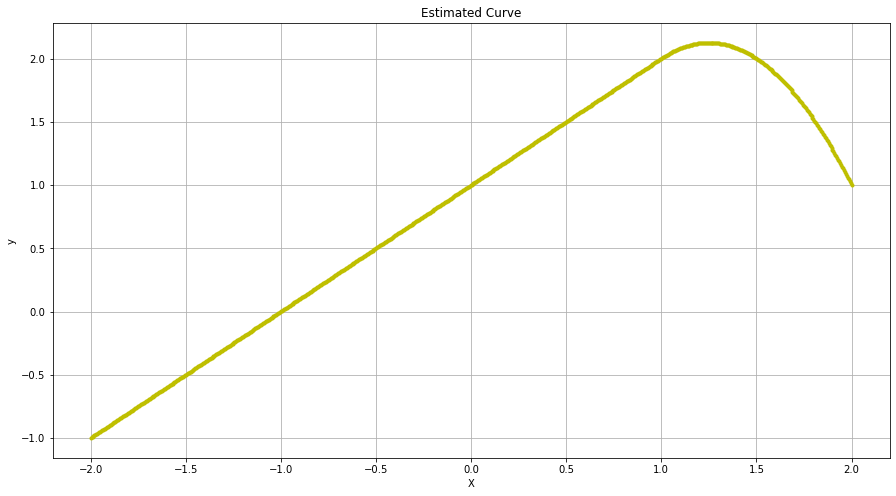

In [94]:
def curve(X):
    β0=1
    β1=1
    β2=-2
    b1=X
    if X>=1:
        b2=(X-1)**2
    else:
        b2=0
    return β0+β1*b1+β2*b2
    

X = np.linspace(-2,2,800)

y=[]
for i in X:
    element=curve(i)
    y.append(element)

fig = plt.figure(figsize=(15, 8))
ax = fig.add_subplot(111)
plt.plot(X, y, marker=".", color='y')
ax.set_xlabel('X')
ax.set_ylabel('y')
ax.set_title('Estimated Curve')
plt.grid()
plt.show()

# 6

In [95]:
Wage = load_data('Wage')
Wage.head(5)

,year,age,maritl,race,education,region,jobclass,health,health_ins,logwage,wage
0,2006,18,1. Never Married,1. White,1. < HS Grad,2. Middle Atlantic,1. Industrial,1. <=Good,2. No,4.318063,75.043154
1,2004,24,1. Never Married,1. White,4. College Grad,2. Middle Atlantic,2. Information,2. >=Very Good,2. No,4.255273,70.476020
2,2003,45,2. Married,1. White,3. Some College,2. Middle Atlantic,1. Industrial,1. <=Good,1. Yes,4.875061,130.982177
3,2003,43,2. Married,3. Asian,4. College Grad,2. Middle Atlantic,2. Information,2. >=Very Good,1. Yes,5.041393,154.685293
4,2005,50,4. Divorced,1. White,2. HS Grad,2. Middle Atlantic,2. Information,1. <=Good,1. Yes,4.318063,75.043154


In [96]:
age = Wage['age']
age.head()

0    18
1    24
2    45
3    43
4    50
Name: age, dtype: int64

In [97]:
y=Wage['wage']
y.head()

0     75.043154
1     70.476020
2    130.982177
3    154.685293
4     75.043154
Name: wage, dtype: float64

In [98]:
X=age

In [99]:
# split the dataset, 25% data in the test set
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.25, random_state=4)

# (a)

In [128]:
import statsmodels.api as sm
from ISLP.models import (summarize, poly, ModelSpec as MS)
from statsmodels.stats.anova import anova_lm
poly_age = MS([poly('age', degree=4)]).fit(Wage)
M = sm.OLS(y, poly_age.transform(Wage)).fit()
summarize(M)

,coef,std err,t,P>|t|
intercept,111.7036,0.729,153.283,0.000
"poly(age, degree=4)[0]",447.0679,39.915,11.201,0.000
"poly(age, degree=4)[1]",-478.3158,39.915,-11.983,0.000
"poly(age, degree=4)[2]",125.5217,39.915,3.145,0.002
"poly(age, degree=4)[3]",-77.9112,39.915,-1.952,0.051


In [115]:

poly_age2 = MS([poly('age')]).fit(Wage)
M2 = sm.OLS(y, poly_age2.transform(Wage)).fit()
summarize(M2)

,coef,std err,t,P>|t|
intercept,111.7036,0.747,149.484,0.0
"poly(age, degree=1)",447.0679,40.929,10.923,0.0


In [116]:
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
pipe = Pipeline(steps=[
    ('poly', PolynomialFeatures(include_bias=False)),
    ('model', LinearRegression()),
])

search = GridSearchCV(
    estimator=pipe,
    param_grid={'poly__degree': [1,2,3,4,5]},
    scoring='neg_mean_squared_error',
    cv=5,
)

search.fit(Wage[['age']], Wage.wage)

first = -search.cv_results_['mean_test_score']

In [117]:
print(first)

[1675.01423805 1599.59822685 1594.72621626 1593.91410391 1595.43313111]


In [118]:
best=search.best_estimator_

In [119]:
print(best)

Pipeline(steps=[('poly', PolynomialFeatures(degree=4, include_bias=False)),
                ('model', LinearRegression())])


In [120]:
 models = [MS([poly('age', degree=d)])
 for d in range(1, 6)]
 Xs = [model.fit_transform(Wage) for model in models]
 anova_lm(*[sm.OLS(y, X_).fit()
 for X_ in Xs])

,df_resid,ssr,df_diff,ss_diff,F,Pr(>F)
0,2998.0,5.022216e+06,0.0,NaN,NaN,NaN
1,2997.0,4.793430e+06,1.0,228786.010128,143.593107,2.363850e-32
2,2996.0,4.777674e+06,1.0,15755.693664,9.888756,1.679202e-03
3,2995.0,4.771604e+06,1.0,6070.152124,3.809813,5.104620e-02
4,2994.0,4.770322e+06,1.0,1282.563017,0.804976,3.696820e-01


In [121]:
age_grid = np.linspace(age.min(),
age.max(),100)
age_df = pd.DataFrame({'age': age_grid})
age_df.head()

,age
0,18.000000
1,18.626263
2,19.252525
3,19.878788
4,20.505051


In [122]:
X_test.head()

571     39
1674    35
2858    42
331     35
1295    58
Name: age, dtype: int64

In [124]:
X_test_df = pd.DataFrame({'age': X_test})
X_test_df.head()

,age
571,39
1674,35
2858,42
331,35
1295,58


In [140]:
newX = poly_age.transform(age_df)

In [141]:
preds = M.get_prediction(newX)
bands = preds.conf_int(alpha=0.05)

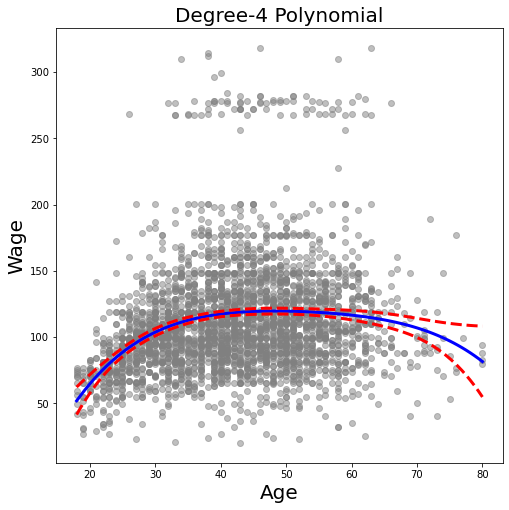

In [144]:

fig, ax = subplots(figsize=(8,8))
ax.scatter(age, y, facecolor='gray', alpha=0.5)
for val, ls in zip([preds.predicted_mean,bands[:,0],bands[:,1]],['b','r--','r--']):
    ax.plot(age_df.values, val, ls, linewidth=3)
ax.set_title( 'Degree-4 Polynomial', fontsize=20)
ax.set_xlabel('Age', fontsize=20)
ax.set_ylabel('Wage', fontsize=20);


In [145]:
newX = poly_age.transform(X_test_df)

In [146]:
preds = M.get_prediction(newX)
bands = preds.conf_int(alpha=0.05)

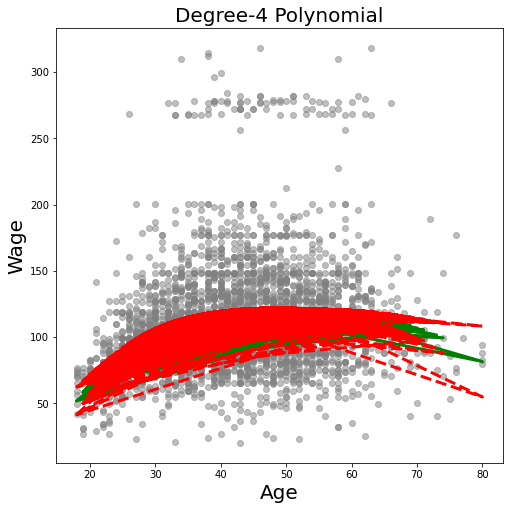

In [147]:

fig, ax = subplots(figsize=(8,8))
ax.scatter(age, y, facecolor='gray', alpha=0.5)
for val, ls in zip([preds.predicted_mean,bands[:,0],bands[:,1]],['g','r--','r--']):
    ax.plot(X_test_df.values, val, ls, linewidth=3)
ax.set_title( 'Degree-4 Polynomial', fontsize=20)
ax.set_xlabel('Age', fontsize=20)
ax.set_ylabel('Wage', fontsize=20);


# (b)

In [150]:
 cut_age = pd.qcut(age, 4)
 
 summarize(sm.OLS(y, pd.get_dummies(cut_age)).fit())

,coef,std err,t,P>|t|
"(17.999, 33.75]",94.1584,1.478,63.692,0.0
"(33.75, 42.0]",116.6608,1.470,79.385,0.0
"(42.0, 51.0]",119.1887,1.416,84.147,0.0
"(51.0, 80.0]",116.5717,1.559,74.751,0.0


In [151]:
 cut_age = pd.qcut(age, 3)
 
 summarize(sm.OLS(y, pd.get_dummies(cut_age)).fit())

,coef,std err,t,P>|t|
"(17.999, 37.0]",99.2685,1.260,78.762,0.0
"(37.0, 48.0]",119.7563,1.274,94.011,0.0
"(48.0, 80.0]",116.7918,1.333,87.648,0.0


In [152]:
 cut_age = pd.qcut(age, 2)
 
 summarize(sm.OLS(y, pd.get_dummies(cut_age)).fit())

,coef,std err,t,P>|t|
"(17.999, 42.0]",105.4767,1.062,99.299,0.0
"(42.0, 80.0]",118.0057,1.069,110.430,0.0


In [153]:
 cut_age = pd.qcut(age, 5)
 
 summarize(sm.OLS(y, pd.get_dummies(cut_age)).fit())

,coef,std err,t,P>|t|
"(17.999, 32.0]",92.3224,1.570,58.792,0.0
"(32.0, 39.0]",115.2538,1.719,67.030,0.0
"(39.0, 46.0]",119.5162,1.575,75.879,0.0
"(46.0, 53.0]",116.7134,1.676,69.636,0.0
"(53.0, 80.0]",116.9012,1.735,67.371,0.0


In [154]:
 cut_age = pd.qcut(age, 6)
 
 summarize(sm.OLS(y, pd.get_dummies(cut_age)).fit())

,coef,std err,t,P>|t|
"(17.999, 30.0]",89.5371,1.765,50.716,0.0
"(30.0, 37.0]",108.9999,1.765,61.740,0.0
"(37.0, 42.0]",119.4151,1.871,63.840,0.0
"(42.0, 48.0]",120.0411,1.709,70.237,0.0
"(48.0, 54.0]",117.0123,1.883,62.151,0.0
"(54.0, 80.0]",116.5787,1.851,62.990,0.0


In [155]:
 cut_age = pd.qcut(age, 7)
 
 summarize(sm.OLS(y, pd.get_dummies(cut_age)).fit())

,coef,std err,t,P>|t|
"(17.999, 29.0]",86.7282,1.901,45.619,0.0
"(29.0, 35.0]",107.1893,1.891,56.695,0.0
"(35.0, 40.0]",118.6607,1.945,61.006,0.0
"(40.0, 45.0]",119.4403,1.864,64.075,0.0
"(45.0, 49.0]",119.0404,2.139,55.659,0.0
"(49.0, 55.0]",116.4898,1.916,60.792,0.0
"(55.0, 80.0]",116.4429,1.987,58.593,0.0


In [156]:
 cut_age = pd.qcut(age, 8)
 
 summarize(sm.OLS(y, pd.get_dummies(cut_age)).fit())

,coef,std err,t,P>|t|
"(17.999, 28.0]",84.7401,2.035,41.632,0.0
"(28.0, 33.75]",104.3616,2.119,49.260,0.0
"(33.75, 38.0]",116.6870,2.070,56.363,0.0
"(38.0, 42.0]",116.6349,2.057,56.710,0.0
"(42.0, 46.375]",121.6993,2.101,57.920,0.0
"(46.375, 51.0]",117.1512,1.893,61.892,0.0
"(51.0, 56.0]",116.6067,2.226,52.376,0.0
"(56.0, 80.0]",116.5390,2.155,54.083,0.0


In [183]:

pipe = Pipeline(steps=[
    ('poly', PolynomialFeatures(include_bias=False)),
    ('model', LinearRegression()),
])

search = GridSearchCV(
    estimator=pipe,
    param_grid={'poly__degree': [4]},
    scoring='neg_mean_squared_error',
    cv=5,
)
#cut_age = pd.qcut(age,cuts )
cuts2=search.fit(pd.get_dummies(pd.qcut(age,2 )), Wage.wage)




In [184]:

pipe = Pipeline(steps=[
    ('poly', PolynomialFeatures(include_bias=False)),
    ('model', LinearRegression()),
])

search = GridSearchCV(
    estimator=pipe,
    param_grid={'poly__degree': [4]},
    scoring='neg_mean_squared_error',
    cv=5,
)
#cut_age = pd.qcut(age,cuts )
cuts3=search.fit(pd.get_dummies(pd.qcut(age,3 )), Wage.wage)




In [185]:

pipe = Pipeline(steps=[
    ('poly', PolynomialFeatures(include_bias=False)),
    ('model', LinearRegression()),
])

search = GridSearchCV(
    estimator=pipe,
    param_grid={'poly__degree': [4]},
    scoring='neg_mean_squared_error',
    cv=5,
)
#cut_age = pd.qcut(age,cuts )
cuts4=search.fit(pd.get_dummies(pd.qcut(age,4 )), Wage.wage)




In [186]:

pipe = Pipeline(steps=[
    ('poly', PolynomialFeatures(include_bias=False)),
    ('model', LinearRegression()),
])

search = GridSearchCV(
    estimator=pipe,
    param_grid={'poly__degree': [4]},
    scoring='neg_mean_squared_error',
    cv=5,
)
#cut_age = pd.qcut(age,cuts )
cuts5=search.fit(pd.get_dummies(pd.qcut(age,5 )), Wage.wage)




In [187]:

pipe = Pipeline(steps=[
    ('poly', PolynomialFeatures(include_bias=False)),
    ('model', LinearRegression()),
])

search = GridSearchCV(
    estimator=pipe,
    param_grid={'poly__degree': [4]},
    scoring='neg_mean_squared_error',
    cv=5,
)
#cut_age = pd.qcut(age,cuts )
cuts6=search.fit(pd.get_dummies(pd.qcut(age,6 )), Wage.wage)




In [188]:

pipe = Pipeline(steps=[
    ('poly', PolynomialFeatures(include_bias=False)),
    ('model', LinearRegression()),
])

search = GridSearchCV(
    estimator=pipe,
    param_grid={'poly__degree': [4]},
    scoring='neg_mean_squared_error',
    cv=5,
)
#cut_age = pd.qcut(age,cuts )
cuts7=search.fit(pd.get_dummies(pd.qcut(age,7 )), Wage.wage)




In [189]:

pipe = Pipeline(steps=[
    ('poly', PolynomialFeatures(include_bias=False)),
    ('model', LinearRegression()),
])

search = GridSearchCV(
    estimator=pipe,
    param_grid={'poly__degree': [4]},
    scoring='neg_mean_squared_error',
    cv=5,
)
#cut_age = pd.qcut(age,cuts )
cuts8=search.fit(pd.get_dummies(pd.qcut(age,8 )), Wage.wage)




In [190]:
print(cuts2)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('poly',
                                        PolynomialFeatures(include_bias=False)),
                                       ('model', LinearRegression())]),
             param_grid={'poly__degree': [4]},
             scoring='neg_mean_squared_error')


In [191]:
cuts2.cv_results_

{'mean_fit_time': array([0.01474643]),
 'std_fit_time': array([0.00342521]),
 'mean_score_time': array([0.00464735]),
 'std_score_time': array([0.00375517]),
 'param_poly__degree': masked_array(data=[4],
              mask=[False],
        fill_value='?',
             dtype=object),
 'params': [{'poly__degree': 4}],
 'split0_test_score': array([-1886.90351799]),
 'split1_test_score': array([-1579.72929867]),
 'split2_test_score': array([-1572.26547524]),
 'split3_test_score': array([-1713.02492424]),
 'split4_test_score': array([-1766.01620479]),
 'mean_test_score': array([-1703.58788419]),
 'std_test_score': array([118.47151458]),
 'rank_test_score': array([1])}

In [192]:
cuts3.cv_results_

{'mean_fit_time': array([0.01806049]),
 'std_fit_time': array([0.00263596]),
 'mean_score_time': array([0.00892191]),
 'std_score_time': array([0.00330277]),
 'param_poly__degree': masked_array(data=[4],
              mask=[False],
        fill_value='?',
             dtype=object),
 'params': [{'poly__degree': 4}],
 'split0_test_score': array([-1825.89301155]),
 'split1_test_score': array([-1556.88763826]),
 'split2_test_score': array([-1520.3200526]),
 'split3_test_score': array([-1673.90166593]),
 'split4_test_score': array([-1717.30001627]),
 'mean_test_score': array([-1658.86047692]),
 'std_test_score': array([110.57413237]),
 'rank_test_score': array([1])}

In [195]:
cuts4.cv_results_

{'mean_fit_time': array([0.02366061]),
 'std_fit_time': array([0.00629885]),
 'mean_score_time': array([0.00557742]),
 'std_score_time': array([0.00562271]),
 'param_poly__degree': masked_array(data=[4],
              mask=[False],
        fill_value='?',
             dtype=object),
 'params': [{'poly__degree': 4}],
 'split0_test_score': array([-1805.90479158]),
 'split1_test_score': array([-1561.84864391]),
 'split2_test_score': array([-1512.13688721]),
 'split3_test_score': array([-1653.63393418]),
 'split4_test_score': array([-1678.35673299]),
 'mean_test_score': array([-1642.37619798]),
 'std_test_score': array([101.59714709]),
 'rank_test_score': array([1])}

In [196]:
cuts5.cv_results_

{'mean_fit_time': array([0.04660759]),
 'std_fit_time': array([0.00152269]),
 'mean_score_time': array([0.00941267]),
 'std_score_time': array([0.00542365]),
 'param_poly__degree': masked_array(data=[4],
              mask=[False],
        fill_value='?',
             dtype=object),
 'params': [{'poly__degree': 4}],
 'split0_test_score': array([-1819.62860462]),
 'split1_test_score': array([-1539.17359768]),
 'split2_test_score': array([-1492.60207789]),
 'split3_test_score': array([-1644.64827807]),
 'split4_test_score': array([-1691.30724629]),
 'mean_test_score': array([-1637.47196091]),
 'std_test_score': array([115.56870818]),
 'rank_test_score': array([1])}

In [197]:
cuts6.cv_results_

{'mean_fit_time': array([0.09362712]),
 'std_fit_time': array([0.00233327]),
 'mean_score_time': array([0.01126738]),
 'std_score_time': array([0.00633288]),
 'param_poly__degree': masked_array(data=[4],
              mask=[False],
        fill_value='?',
             dtype=object),
 'params': [{'poly__degree': 4}],
 'split0_test_score': array([-1806.0001232]),
 'split1_test_score': array([-1532.63202151]),
 'split2_test_score': array([-1480.21158007]),
 'split3_test_score': array([-1643.62675461]),
 'split4_test_score': array([-1685.85144673]),
 'mean_test_score': array([-1629.66438522]),
 'std_test_score': array([115.06315371]),
 'rank_test_score': array([1])}

In [198]:
cuts7.cv_results_

{'mean_fit_time': array([0.18239222]),
 'std_fit_time': array([0.00887817]),
 'mean_score_time': array([0.01597924]),
 'std_score_time': array([0.00090419]),
 'param_poly__degree': masked_array(data=[4],
              mask=[False],
        fill_value='?',
             dtype=object),
 'params': [{'poly__degree': 4}],
 'split0_test_score': array([-1799.85128857]),
 'split1_test_score': array([-1544.75779302]),
 'split2_test_score': array([-1467.00738265]),
 'split3_test_score': array([-1644.16318374]),
 'split4_test_score': array([-1673.85259813]),
 'mean_test_score': array([-1625.92644922]),
 'std_test_score': array([113.77430681]),
 'rank_test_score': array([1])}

In [199]:
cuts8.cv_results_

{'mean_fit_time': array([0.18422732]),
 'std_fit_time': array([0.01338262]),
 'mean_score_time': array([0.00964222]),
 'std_score_time': array([0.00788229]),
 'param_poly__degree': masked_array(data=[4],
              mask=[False],
        fill_value='?',
             dtype=object),
 'params': [{'poly__degree': 4}],
 'split0_test_score': array([-1786.84511619]),
 'split1_test_score': array([-1541.70917902]),
 'split2_test_score': array([-1468.70470278]),
 'split3_test_score': array([-1633.32368356]),
 'split4_test_score': array([-1666.61695611]),
 'mean_test_score': array([-1619.43992753]),
 'std_test_score': array([108.81737466]),
 'rank_test_score': array([1])}

In [210]:
newX = poly_age.transform(age_df)


In [211]:
cut_age = pd.qcut(age, 8)
 
cut8M=sm.OLS(y, pd.get_dummies(cut_age)).fit()

In [228]:
pd.get_dummies(cut_age)

,"(17.999, 28.0]","(28.0, 33.75]","(33.75, 38.0]","(38.0, 42.0]","(42.0, 46.375]","(46.375, 51.0]","(51.0, 56.0]","(56.0, 80.0]"
0,1,0,0,0,0,0,0,0
1,1,0,0,0,0,0,0,0
2,0,0,0,0,1,0,0,0
3,0,0,0,0,1,0,0,0
4,0,0,0,0,0,1,0,0
...,...,...,...,...,...,...,...,...
2995,0,0,0,0,1,0,0,0
2996,0,1,0,0,0,0,0,0
2997,1,0,0,0,0,0,0,0
2998,1,0,0,0,0,0,0,0


In [217]:
newX

,intercept,"poly(age, degree=4)[0]","poly(age, degree=4)[1]","poly(age, degree=4)[2]","poly(age, degree=4)[3]"
0,1.0,-0.038625,0.055909,-0.071741,0.086730
1,1.0,-0.037634,0.052445,-0.064068,0.072513
2,1.0,-0.036643,0.049068,-0.056818,0.059599
3,1.0,-0.035652,0.045779,-0.049979,0.047921
4,1.0,-0.034662,0.042576,-0.043544,0.037415
...,...,...,...,...,...
95,1.0,0.055498,0.114987,0.152588,0.134426
96,1.0,0.056489,0.119781,0.164684,0.155650
97,1.0,0.057480,0.124662,0.177306,0.178605
98,1.0,0.058470,0.129630,0.190463,0.203368


In [218]:
cut_age

0       (17.999, 28.0]
1       (17.999, 28.0]
2       (42.0, 46.375]
3       (42.0, 46.375]
4       (46.375, 51.0]
             ...      
2995    (42.0, 46.375]
2996     (28.0, 33.75]
2997    (17.999, 28.0]
2998    (17.999, 28.0]
2999      (51.0, 56.0]
Name: age, Length: 3000, dtype: category
Categories (8, interval[float64, right]): [(17.999, 28.0] < (28.0, 33.75] < (33.75, 38.0] < (38.0, 42.0] < (42.0, 46.375] < (46.375, 51.0] < (51.0, 56.0] < (56.0, 80.0]]

In [222]:
cut_ageX = pd.qcut(age_grid, 8)
cut_ageX

[(17.999, 25.75], (17.999, 25.75], (17.999, 25.75], (17.999, 25.75], (17.999, 25.75], ..., (72.25, 80.0], (72.25, 80.0], (72.25, 80.0], (72.25, 80.0], (72.25, 80.0]]
Length: 100
Categories (8, interval[float64, right]): [(17.999, 25.75] < (25.75, 33.5] < (33.5, 41.25] < (41.25, 49.0] < (49.0, 56.75] < (56.75, 64.5] < (64.5, 72.25] < (72.25, 80.0]]

In [223]:
cut8M

In [230]:
cut_age = pd.qcut(age, 8)
 
#cut8M=sm.OLS(y, pd.get_dummies(cut_age)).fit()
preds = sm.OLS(y, pd.get_dummies(cut_age)).fit().get_prediction(pd.get_dummies(cut_ageX))

In [231]:
#preds = cut8M.get_prediction(cut_ageX)
bands = preds.conf_int(alpha=0.05)



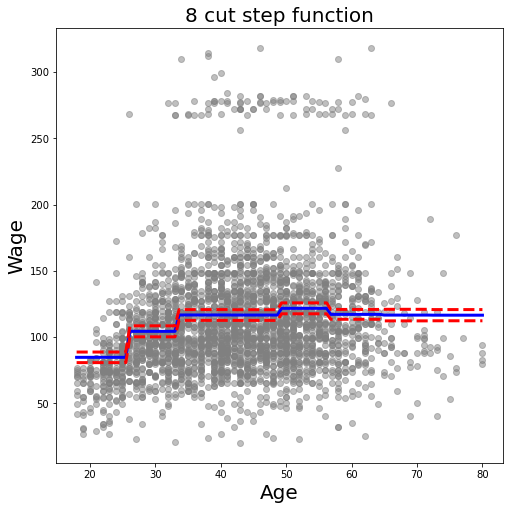

In [232]:
fig, ax = subplots(figsize=(8,8))
ax.scatter(age, y, facecolor='gray', alpha=0.5)
for val, ls in zip([preds.predicted_mean,bands[:,0],bands[:,1]],['b','r--','r--']):
    ax.plot(age_df.values, val, ls, linewidth=3)
ax.set_title( '8 cut step function', fontsize=20)
ax.set_xlabel('Age', fontsize=20)
ax.set_ylabel('Wage', fontsize=20);